In [ ]:
!pip install -r requirements.txt

In [3]:
from utils import *

In [5]:
path = untar_data(URLs.PETS)/'images'
def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=21,
    label_func=is_cat, item_tfms=Resize(224))
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

A new version of this dataset is available, downloading...


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.147673,0.017700,0.006089,00:47


epoch,train_loss,valid_loss,error_rate,time
0,0.050325,0.014492,0.005413,00:51


In [6]:
img = PILImage.create('chapter1_cat_example.jpg')
x, = first(dls.test_dl([img]))

In [11]:
model = learn.model[0]
x.shape

torch.Size([1, 3, 224, 224])

In [20]:
class Hook():
  def hook_func(self, model, input, output): 
    self.stored = output.detach().clone()
    # save a copy of output
    # class provides a state.. where we can store

hook_output = Hook()

# actually we need to attach to last layer.. 
# lets see how that works
hook = learn.model[0].register_forward_hook(hook_output.hook_func)

with torch.no_grad():
  outs = learn.model.eval()(x)

# now the hook stores vals of the last layer outs..
act = hook_output.stored[0] # why zero tho --> to pick first elem of batch.. batchsize is  1

# eval_batch --> (b, 3, 224, 224)
# final weight matrix --> (2, no_of_activations)

# act --> (acts, rows, cols ) === acts is like F filter

cam_map = torch.einsum("ck, kij -> cij", learn.model[1][-1].weight, act)

In [30]:
cam_map.shape
# this means... we multiplied weight to first CNN part output
# and got, for each possible class --> how do the image in final dimension weigh...

torch.Size([2, 7, 7])

In [17]:
#learn.model[1]
# this is the final layer sort of.. the feed forward part.. 
#

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=False)
)

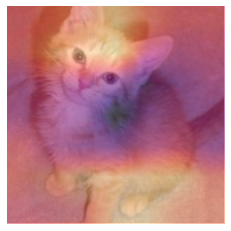

In [36]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
# x_dec.show(ctx=ax)
x_dec.show(ctx=ax)
ax.imshow(cam_map[1].detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

In [37]:
hook.remove()

In [38]:
class Hook():
  def __init__(self, model):
    self.hook = model.register_forward_hook(self.hook_func)

  def hook_func(self, model, inps, ops):
    self.stored = ops.detach().clone()

  def __enter__(self, *args): return self

  def __exit__(self, *args): self.hook.remove()

In [39]:
with Hook(learn.model[0]) as hook_output:
  with torch.no_grad():
    ops = learn.model.eval()(x.cuda()) 
  act = hook_output.stored


In [61]:
class Hook_back():
  def __init__(self, model):
    self.hook = model.register_backward_hook(self.hook_func)

  def hook_func(self, model, g_inps, g_ops):
    
    self.stored = g_ops[0].detach().clone()

  def __enter__(self, *args): return self

  def __exit__(self, *args): self.hook.remove()


In [62]:
cls = 1
with Hook_back(learn.model[0]) as hookg:
    with Hook(learn.model[0]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward() # need not always do loss.backward() :)
    grad = hookg.stored

In [64]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)
cam_map.shape

torch.Size([7, 7])

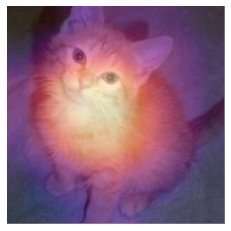

In [66]:
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

In [69]:
torch.einsum("abc, ade -> de", w, act[0])

tensor([[-0.0257, -0.0037,  0.0765,  0.0783,  0.0656,  0.0505,  0.0108],
        [ 0.0254,  0.1160,  0.1848,  0.1898,  0.1340,  0.1050,  0.0362],
        [ 0.1033,  0.2678,  0.3576,  0.3457,  0.2212,  0.1081,  0.0365],
        [ 0.1160,  0.2769,  0.3578,  0.3788,  0.2481,  0.1384,  0.0377],
        [ 0.0667,  0.2135,  0.3152,  0.3200,  0.2344,  0.1168,  0.0329],
        [ 0.0211,  0.0860,  0.1714,  0.1891,  0.1471,  0.0561,  0.0066],
        [-0.0119,  0.0277,  0.0689,  0.0919,  0.0405,  0.0146,  0.0057]], device='cuda:0')

In [70]:
cam_map

tensor([[-0.0257, -0.0037,  0.0765,  0.0783,  0.0656,  0.0505,  0.0108],
        [ 0.0254,  0.1160,  0.1848,  0.1898,  0.1340,  0.1050,  0.0362],
        [ 0.1033,  0.2678,  0.3576,  0.3457,  0.2212,  0.1081,  0.0365],
        [ 0.1160,  0.2769,  0.3578,  0.3788,  0.2481,  0.1384,  0.0377],
        [ 0.0667,  0.2135,  0.3152,  0.3200,  0.2344,  0.1168,  0.0329],
        [ 0.0211,  0.0860,  0.1714,  0.1891,  0.1471,  0.0561,  0.0066],
        [-0.0119,  0.0277,  0.0689,  0.0919,  0.0405,  0.0146,  0.0057]], device='cuda:0')